In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../fem')
from heatconduction2d import main, postprocessdata, datasetgenerator
from randompolynomials import *

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON

In [39]:
simparams = {'inputdata': 'poly',
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

trainingdataparams = {'N_sensornodes': 144,
                      'N_outputnodes': 100,
                      'N_sims': 3}

params = {}
params['simparams'] = simparams
params['trainingdataparams'] = trainingdataparams

c_theta = np.random.uniform(-0.1, 0.1, 10)
c_f = np.random.uniform(-0.1, 0.1, 10)
c_etab = np.random.uniform(-0.1, 0.1, 4)
c_etat = np.random.uniform(-0.1, 0.1, 4)

theta = randompoly2DO3sqr(c_theta)
f = randompoly2DO3sqr(c_f)
etab = randompoly1DO3(c_etab)
etat = randompoly1DO3(c_etat)
gl = 0
gr = 0

inputs = {'theta': theta,
          'f': f,
          'etab': etab,
          'etat': etat,
          'gl': gl,
          'gr': gr}

outputs = main(params, inputs, save=False, savedir='../../../trainingdata', label='test')

# generatedataset(params, save=True, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-16


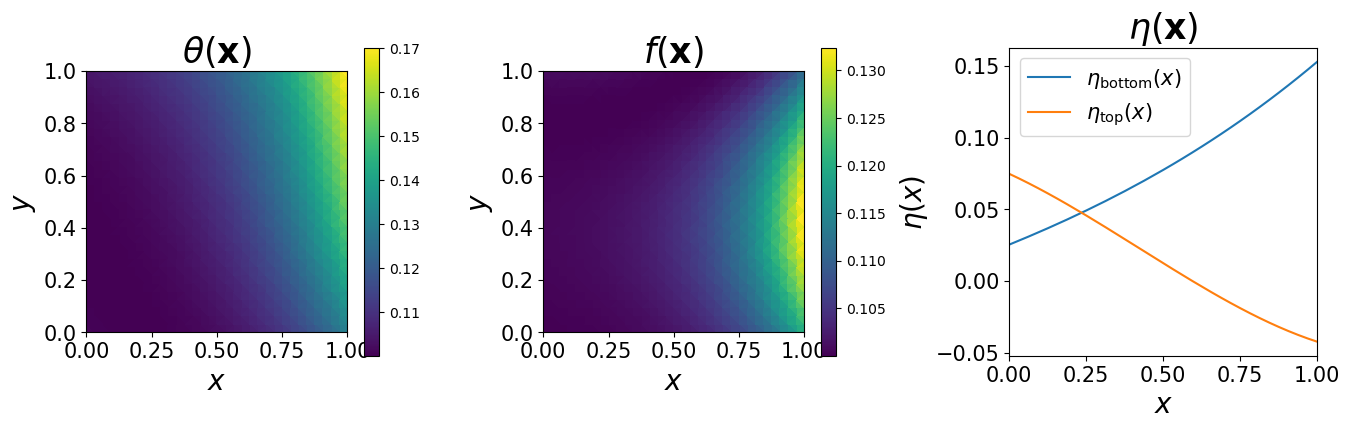

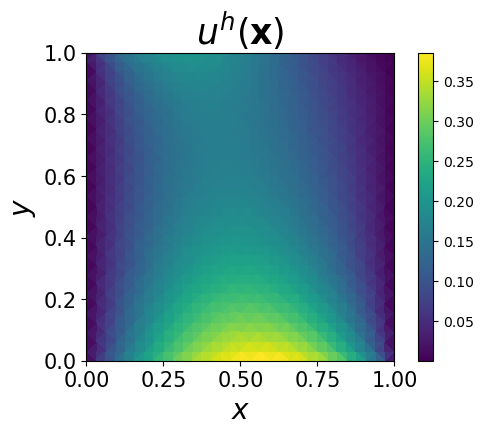

In [40]:
x = outputs['x']
u = outputs['u']

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

ax = axs[0]
plot0 = ax.tripcolor(x[:,0], x[:,1], theta(x[:,0],x[:,1]))
ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.tripcolor(x[:,0], x[:,1], f(x[:,0],x[:,1]))
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]
ax.plot(x[:,0], etab(x[:,0]), label=r'$\eta_\mathrm{bottom}(x)$')
ax.plot(x[:,0], etat(x[:,0]), label=r'$\eta_\mathrm{top}(x)$')
ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.legend(fontsize=15)
ax.set_box_aspect(1)

# plt.savefig("hc2d_theta_f_eta.svg", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x[:,0], x[:,1], u)
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u.svg", bbox_inches='tight')


In [41]:
data_postprocessed = postprocessdata(params, inputs, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

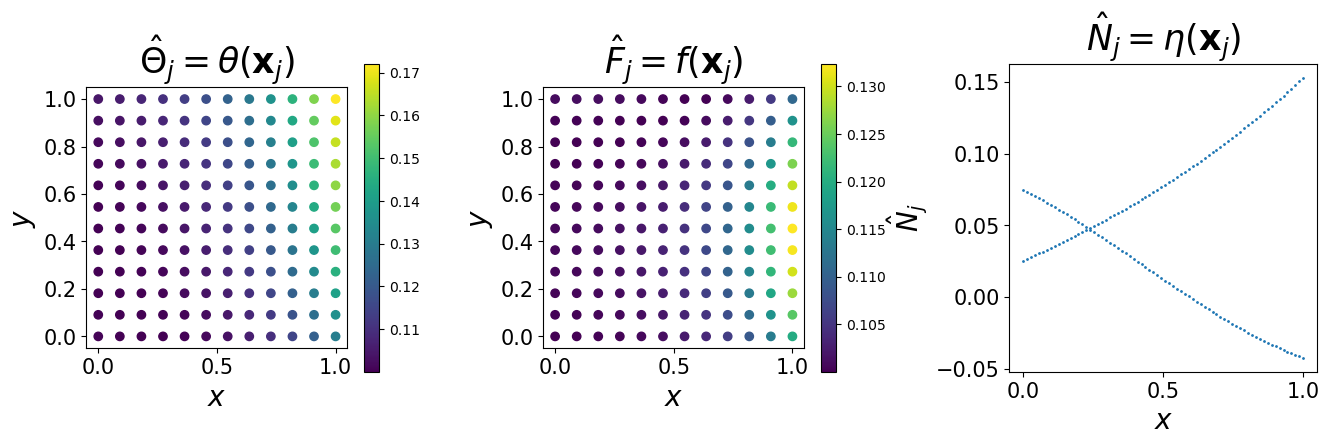

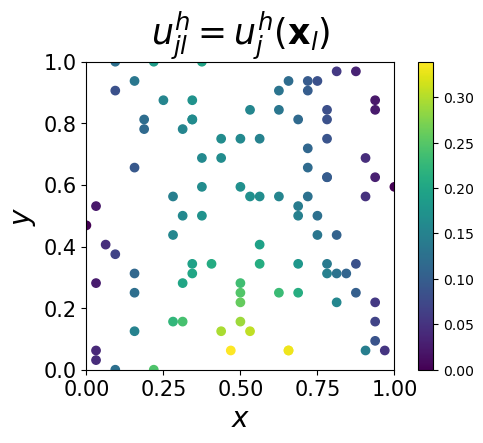

In [42]:
#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]
ax = axs[0]
plot0 = ax.scatter(x_sensor, y_sensor, c=Theta)
ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot0 = ax.scatter(x_sensor, y_sensor, c=F)
ax.set_title(r"$\hat{F}_j=f(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

sensornodes_Gamma = np.linspace(0,1,int(trainingdataparams['N_sensornodes']/2))
ax = axs[2]
ax.scatter(sensornodes_Gamma, N[:int(len(sensornodes_Gamma))], s=1, color='C0')#, label=r'$\eta_\mathrm{bottom}(x)$')
ax.scatter(sensornodes_Gamma, N[int(len(sensornodes_Gamma)):], s=1, color='C0')#, label=r'$\eta_\mathrm{top}(x)$')
ax.set_title(r"$\hat{N}_j = \eta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\hat{N}_j$', fontsize=size_axeslabels)
# ax.set_xlim(0,1)
# ax.legend(fontsize=15)
ax.set_box_aspect(1)

# plt.savefig("hc2d_theta_f_eta_postprocessed.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x[:,0], x[:,1], c=u)
ax.set_title(r"$u^h_{jl}=u^h_j(\mathbf{x}_l)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u_postprocessed.svg", bbox_inches='tight')


In [43]:
model = VarMiON
label = '5000epochs'
logdir = '../../../nnlogs'
sublogdir = 'best'
map_location = 'cpu'
model = loadmodelfromlabel(model, label, logdir, sublogdir, map_location)
u_hat = model.simforward(Theta, F, N, x)

FileNotFoundError: [Errno 2] No such file or directory: '../../../nnlogs/best/5000epochs'

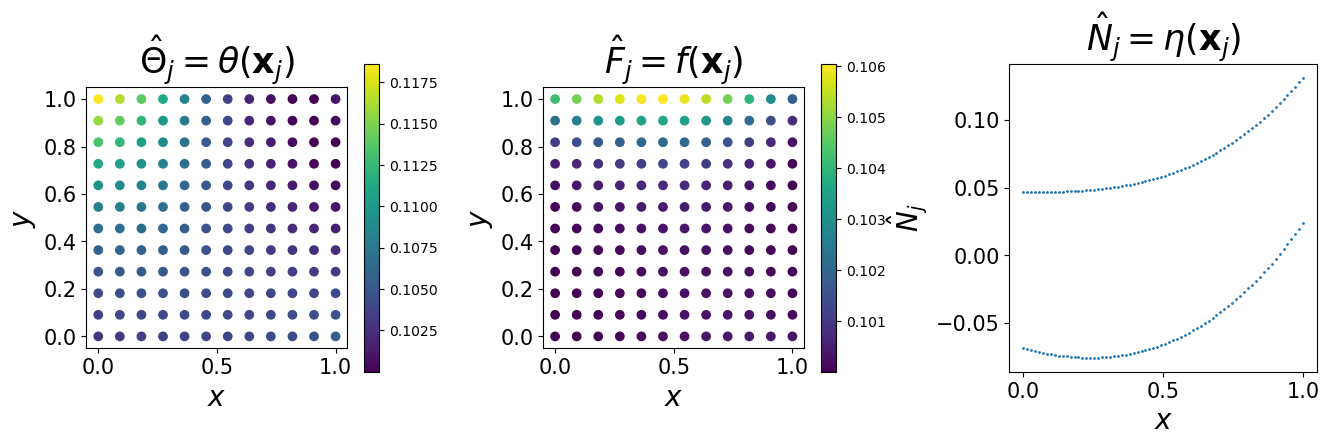

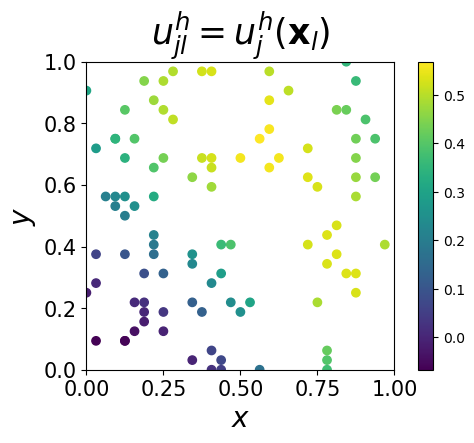

In [36]:
#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]
ax = axs[0]
plot0 = ax.scatter(x_sensor, y_sensor, c=Theta)
ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot0 = ax.scatter(x_sensor, y_sensor, c=F)
ax.set_title(r"$\hat{F}_j=f(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

sensornodes_Gamma = np.linspace(0,1,int(trainingdataparams['N_sensornodes']/2))
ax = axs[2]
ax.scatter(sensornodes_Gamma, N[:int(len(sensornodes_Gamma))], s=1, color='C0')#, label=r'$\eta_\mathrm{bottom}(x)$')
ax.scatter(sensornodes_Gamma, N[int(len(sensornodes_Gamma)):], s=1, color='C0')#, label=r'$\eta_\mathrm{top}(x)$')
ax.set_title(r"$\hat{N}_j = \eta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\hat{N}_j$', fontsize=size_axeslabels)
# ax.set_xlim(0,1)
# ax.legend(fontsize=15)
ax.set_box_aspect(1)

# plt.savefig("hc2d_theta_f_eta_postprocessed.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x[:,0], x[:,1], c=u_hat)
ax.set_title(r"$u^h_{jl}=u^h_j(\mathbf{x}_l)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u_postprocessed.svg", bbox_inches='tight')
